In [1]:
import pandas  as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from glob import glob
%matplotlib inline

In [2]:
import random
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed


In [3]:
%cd /content/drive/MyDrive/Unet

/content/drive/MyDrive/Unet


In [ ]:
!unzip Water_bodies.zip

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1822.jpg  
  inf

In [4]:
w, h = 256, 256


In [5]:
train = sorted(glob("/content/drive/MyDrive/Unet/Water Bodies Dataset/Images/*"))
masks = sorted(glob("/content/drive/MyDrive/Unet/Water Bodies Dataset/Masks/*"))

In [6]:
print(len(train))
print(len(masks))

2841
2841


In [7]:
x = np.zeros((len(train) , h, w, 3 ) , dtype=np.float32)
y = np.zeros((len(masks) , h, w, 1 ) , dtype=np.float32)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img , img_to_array , array_to_img
from tensorflow.keras.layers import Conv2D , Input , MaxPool2D , UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


In [26]:
for n, (img, mimg) in tqdm(enumerate(zip(train, masks))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  x[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [36]:
np.save('/content/drive/MyDrive/Unet/x.npy', x)
np.save('/content/drive/MyDrive/Unet/y.npy', y)



In [37]:
x = np.load('/content/drive/MyDrive/Unet/x.npy')
y = np.load('/content/drive/MyDrive/Unet/y.npy')
print(x.shape, y.shape)

(2841, 256, 256, 3) (2841, 256, 256, 1)


In [38]:
train_x, test_x, train_y , test_y  = train_test_split(x, y , test_size=0.1 , random_state=42)
print(train_x.shape , test_x.shape , train_y.shape , test_y.shape)

(2556, 256, 256, 3) (285, 256, 256, 3) (2556, 256, 256, 1) (285, 256, 256, 1)


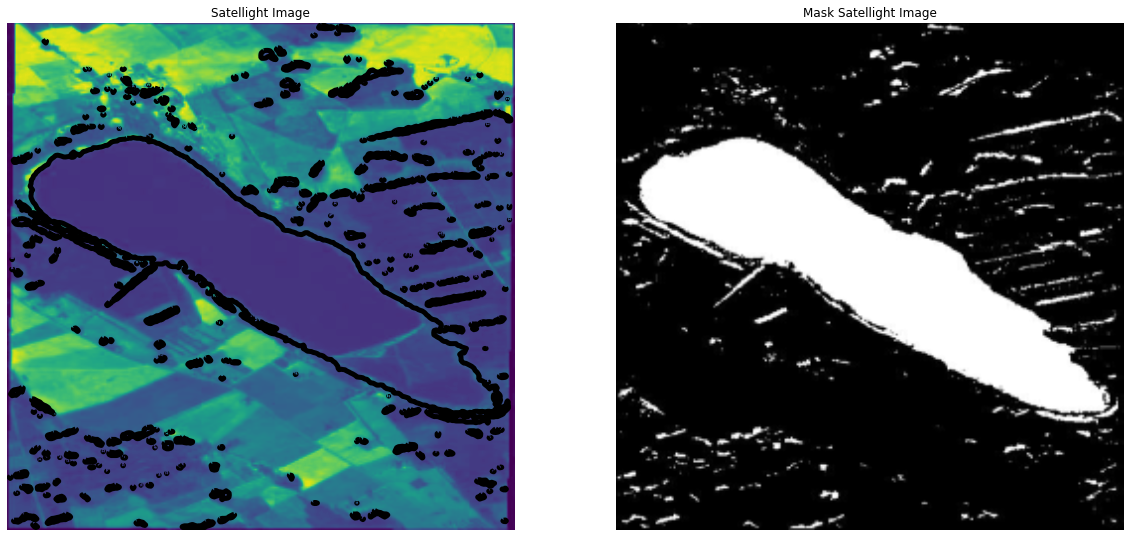

In [39]:
ix = random.randint(0, len(train_x))
has_mask = train_y[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(train_x[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(train_y[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(train_y[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [40]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [42]:
image_size=256
def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((image_size, image_size, 3))
    
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
    
  bn = bottleneck(p4, f[4])
    
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
    
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model

In [43]:
model = UNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    
]

results = model.fit(train_x, train_y, batch_size=32, epochs=100, callbacks=callbacks, validation_data=(test_x, test_y), use_multiprocessing=True)

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 0.5744 - acc: 0.5746
Epoch 00001: val_loss improved from inf to 0.48845, saving model to model-Unet.h5
80/80 [==============================] - 15s 167ms/step - loss: 0.5744 - acc: 0.5746 - val_loss: 0.4885 - val_acc: 0.5912 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.4604 - acc: 0.6156
Epoch 00002: val_loss improved from 0.48845 to 0.47096, saving model to model-Unet.h5
80/80 [==============================] - 13s 160ms/step - loss: 0.4604 - acc: 0.6156 - val_loss: 0.4710 - val_acc: 0.5995 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.4298 - acc: 0.6316
Epoch 00003: val_loss improved from 0.47096 to 0.40878, saving model to model-Unet.h5
80/80 [==============================] - 13s 160ms/step - loss: 0.4298 - acc: 0.6316 - val_loss: 0.4088 - val_acc: 0.6420 - lr: 0.0010
Epoch 4/100
80/80 [==============================] - ETA: 0s - loss: 0.

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

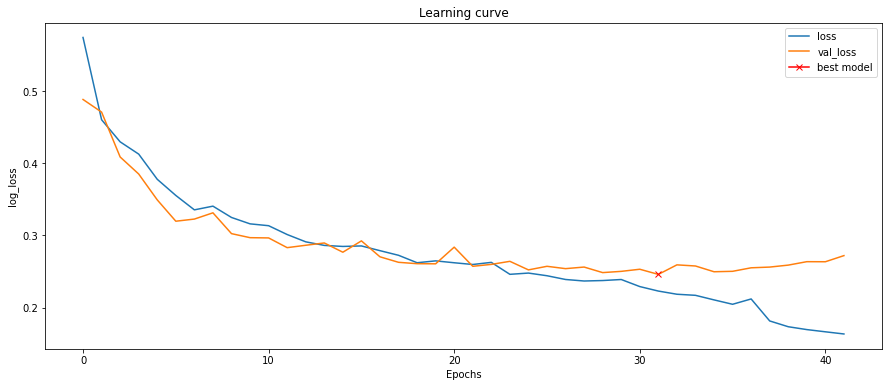

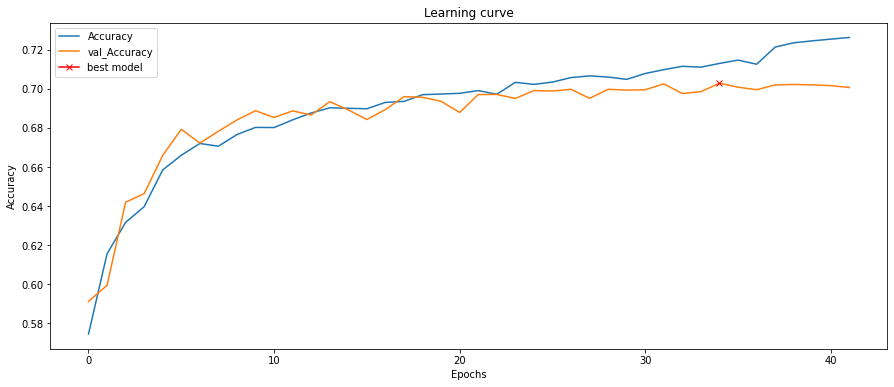

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["acc"], label="Accuracy")
plt.plot(results.history["val_acc"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
model.evaluate(test_x, test_y, verbose=1)

9/9 [==============================] - 0s 46ms/step - loss: 0.2721 - acc: 0.7006


[0.2721339464187622, 0.7006232142448425]

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [44]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [45]:
new_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_190 (Conv2D)            (None, 256, 256, 16  448         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_191 (Conv2D)            (None, 256, 256, 16  2320        ['conv2d_190[0][0]']             
                                )                                                          

In [46]:
loss, acc = new_model.evaluate(test_x, test_y, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_x).shape)

9/9 - 1s - loss: 0.2721 - acc: 0.7006 - 951ms/epoch - 106ms/step
Restored model, accuracy: 70.06%
(285, 256, 256, 1)
